In [2]:
! pip install scipy

The initial mode images indicate that the structure behaves as a leaky “floss-type” waveguide, consistent with what we expect from phospholipid assemblies with low refractive-index contrast and structural imperfections. The next step is to experimentally verify this behaviour using an 800 nm excitation beam, allowing us to probe the extent of leakage, scattering, and any residual confinement along the myelin-like structure.

Solving eigenproblem (this can be the slow step)...


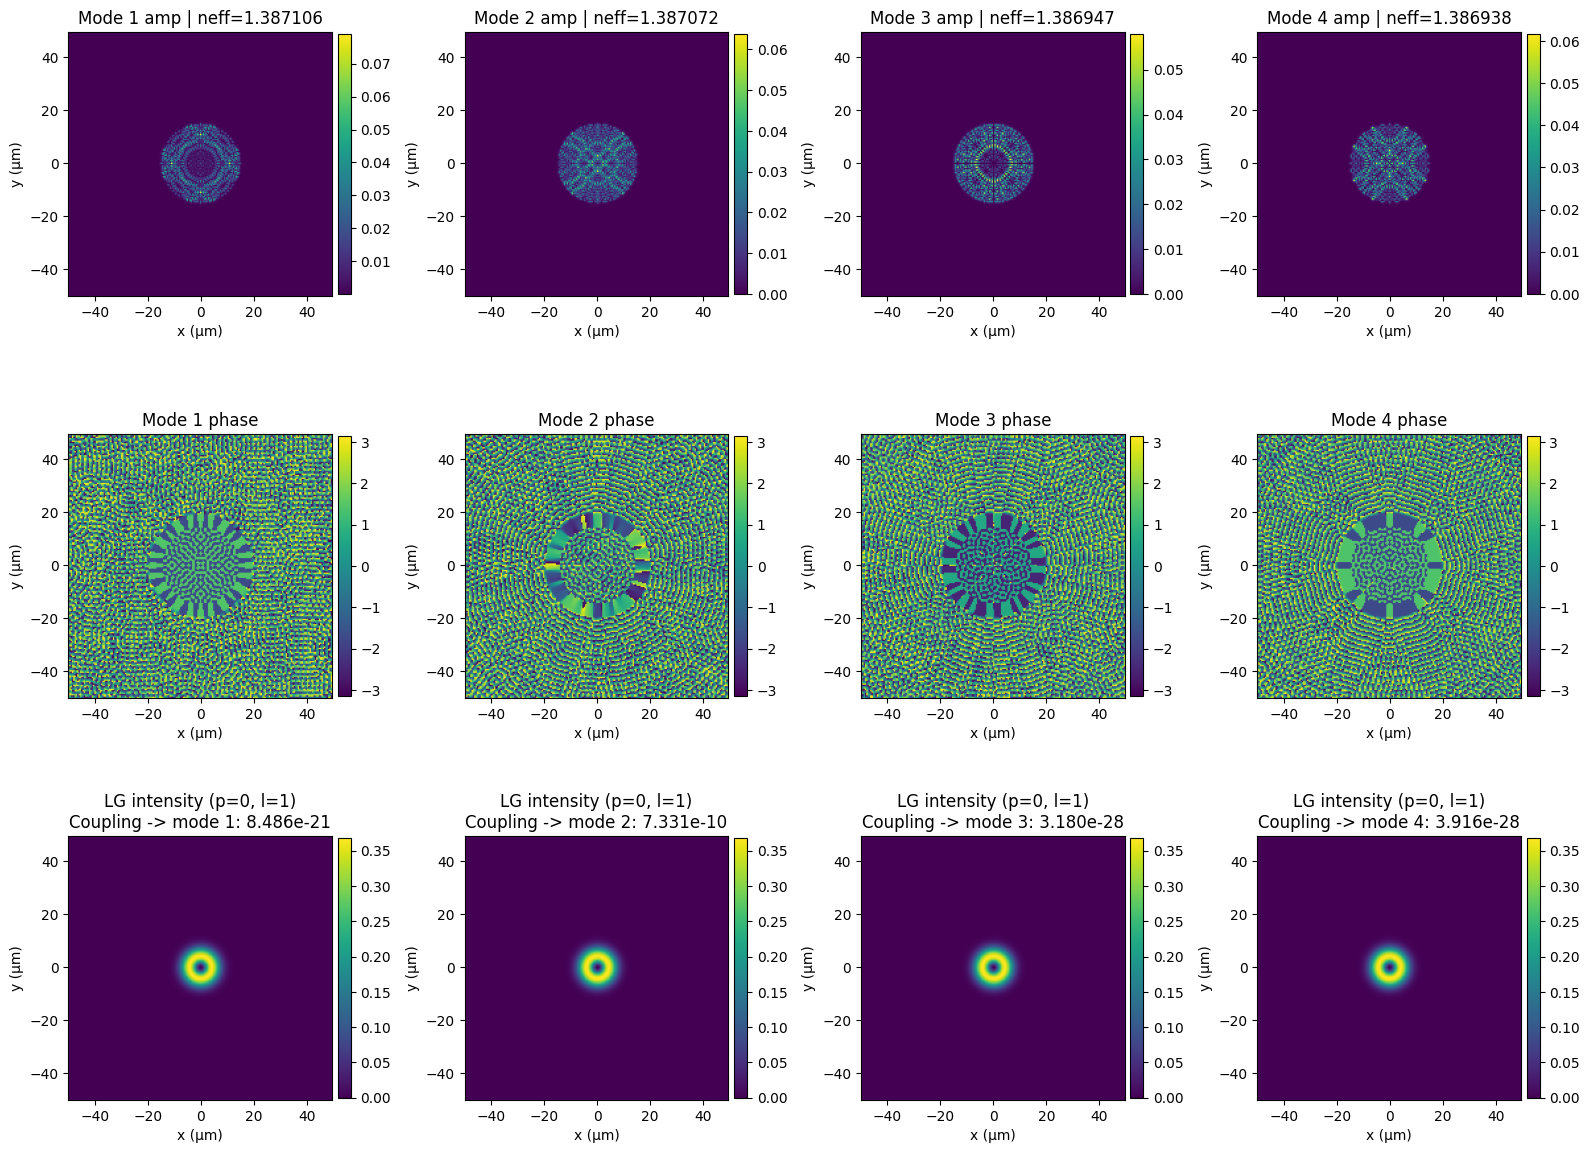

Computed effective indices (neff) and coupling fractions to LG beam:
Mode 1: neff = 1.387106  imag = -3.282e-17  | coupling = 8.486e-21
Mode 2: neff = 1.387072  imag = -5.424e-18  | coupling = 7.331e-10
Mode 3: neff = 1.386947  imag = -4.466e-18  | coupling = 3.180e-28
Mode 4: neff = 1.386938  imag = -6.135e-18  | coupling = 3.916e-28
Saved figure and arrays to fdfd_pml_overlap_outputs


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import eigs
from scipy.special import genlaguerre
from scipy.sparse import eye, diags, kron
import os, math

wavelength = 800e-9
c0 = 299792458.0
k0 = 2 * np.pi / wavelength


nx, ny = 200, 200
physical_size = 100e-6
dx = physical_size / nx
dy = physical_size / ny

r_inner = 15e-6
r_outer = 20e-6


n_out = 1.33
n_wall = 1.46
n_core = 1.33


pml_thickness = 12
pml_max_sigma = 80.0


lg_p = 0
lg_l = 1
w0 = 6e-6
beam_offset = (0.0, 0.0)


nev = 4
target_near = n_wall * 0.95
sigma = (k0 * target_near)**2
maxiter = 1000
tol = 1e-5


x = (np.arange(nx) - nx//2) * dx
y = (np.arange(ny) - ny//2) * dy
X, Y = np.meshgrid(x, y, indexing='xy')
R = np.sqrt(X**2 + Y**2)

eps = np.ones((ny, nx)) * n_out**2
eps[(R >= r_inner) & (R <= r_outer)] = n_wall**2
eps[R < r_inner] = n_core**2


sigma_x = np.zeros(nx)
sigma_y = np.zeros(ny)
grad_order = 2.0
for i in range(pml_thickness):
    frac = ((pml_thickness - i) / pml_thickness)**grad_order
    sigma_val = pml_max_sigma * frac**2
    sigma_x[i] = sigma_val
    sigma_x[-1 - i] = sigma_val
    sigma_y[i] = sigma_val
    sigma_y[-1 - i] = sigma_val

Sigma = np.zeros_like(eps)
for j in range(ny):
    for i in range(nx):
        Sigma[j, i] = sigma_x[i] + sigma_y[j]


omega = 2 * np.pi * c0 / wavelength
eps0 = 8.854187817e-12
eps_complex = eps.astype(np.complex128) * (1 - 1j * Sigma / (omega * eps0 + 1e-30))


nxny = nx * ny
eps_flat = eps_complex.ravel()

def laplacian_2d(nx, ny, dx, dy):
    ex = np.ones(nx)
    Dx = diags([ex, -2*ex, ex], offsets=[-1, 0, 1], shape=(nx, nx)) / dx**2
    ey = np.ones(ny)
    Dy = diags([ey, -2*ey, ey], offsets=[-1, 0, 1], shape=(ny, ny)) / dy**2
    Ix = eye(nx); Iy = eye(ny)
    L = kron(Iy, Dx) + kron(Dy, Ix)
    return L.tocsr()

L = laplacian_2d(nx, ny, dx, dy)

A = -L + diags((k0**2) * eps_flat, 0, format='csr')

print("Solving eigenproblem (this can be the slow step)...")
eigvals, eigvecs = eigs(A, k=nev, sigma=sigma, which='LM', tol=tol, maxiter=maxiter)


order = np.argsort(-np.real(eigvals))
eigvals = eigvals[order]
eigvecs = eigvecs[:, order]

beta2 = eigvals
beta = np.sqrt(beta2)
neff = beta / k0


def LG_field(p, l, r, phi, w0):
    rho = np.sqrt(2) * r / w0
    radial = np.exp(-rho**2/2) * (rho**abs(l))
    if p > 0:
        Lpl = genlaguerre(p, abs(l))(rho**2)
        radial *= Lpl
    az = np.exp(1j * l * phi)
    return radial * az

Xb = X - beam_offset[0]
Yb = Y - beam_offset[1]
Rb = np.sqrt(Xb**2 + Yb**2)
Phib = np.arctan2(Yb, Xb)
E_lg = LG_field(lg_p, lg_l, Rb, Phib, w0)
dA = dx * dy


E_lg_flat = E_lg.ravel()
P_lg = np.vdot(E_lg_flat, E_lg_flat) * dA
E_lg_norm = E_lg_flat / np.sqrt(P_lg + 1e-30)

couplings = []
for i in range(eigvecs.shape[1]):
    mode = eigvecs[:, i]
    P_mode = np.vdot(mode, mode) * dA
    mode_norm = mode / np.sqrt(P_mode + 1e-30)
    overlap = np.vdot(mode_norm.conj(), E_lg_norm) * dA
    coupling = np.abs(overlap)**2
    couplings.append(coupling.real)

num_plot = min(4, eigvecs.shape[1])
fig, axs = plt.subplots(3, num_plot, figsize=(4*num_plot, 12))
axs = np.atleast_2d(axs)

axs[0,0].imshow(np.real(eps_complex), extent=[x[0]*1e6, x[-1]*1e6, y[0]*1e6, y[-1]*1e6], origin='lower')
axs[0,0].set_title('Re(eps) (with PML imaginary part)')
axs[0,0].set_xlabel('x (µm)'); axs[0,0].set_ylabel('y (µm)')

for i in range(num_plot):
    mode2d = eigvecs[:, i].reshape((ny, nx))
    amp = np.abs(mode2d)
    ph = np.angle(mode2d)
    im1 = axs[0, i].imshow(amp, extent=[x[0]*1e6, x[-1]*1e6, y[0]*1e6, y[-1]*1e6], origin='lower')
    axs[0, i].set_title(f'Mode {i+1} amp | neff={neff[i].real:.6f}')
    axs[0, i].set_xlabel('x (µm)'); axs[0, i].set_ylabel('y (µm)')
    fig.colorbar(im1, ax=axs[0, i], fraction=0.046, pad=0.02)

    im2 = axs[1, i].imshow(ph, extent=[x[0]*1e6, x[-1]*1e6, y[0]*1e6, y[-1]*1e6], origin='lower', vmin=-np.pi, vmax=np.pi)
    axs[1, i].set_title(f'Mode {i+1} phase')
    axs[1, i].set_xlabel('x (µm)'); axs[1, i].set_ylabel('y (µm)')
    fig.colorbar(im2, ax=axs[1, i], fraction=0.046, pad=0.02)

    im3 = axs[2, i].imshow(np.abs(E_lg)**2, extent=[x[0]*1e6, x[-1]*1e6, y[0]*1e6, y[-1]*1e6], origin='lower')
    axs[2, i].set_title(f'LG intensity (p={lg_p}, l={lg_l})\nCoupling -> mode {i+1}: {couplings[i]:.3e}')
    axs[2, i].set_xlabel('x (µm)'); axs[2, i].set_ylabel('y (µm)')
    fig.colorbar(im3, ax=axs[2, i], fraction=0.046, pad=0.02)

plt.tight_layout()
plt.show()

print("Computed effective indices (neff) and coupling fractions to LG beam:")
for i in range(len(neff)):
    coup = couplings[i] if i < len(couplings) else float('nan')
    print(f"Mode {i+1}: neff = {neff[i].real:.6f}  imag = {neff[i].imag:.3e}  | coupling = {coup:.3e}")

out_dir = 'fdfd_pml_overlap_outputs'
os.makedirs(out_dir, exist_ok=True)
fig.savefig(os.path.join(out_dir, 'fdfd_pml_modes_and_lg.png'), dpi=300)
np.save(os.path.join(out_dir, 'neff.npy'), neff)
np.save(os.path.join(out_dir, 'eigvecs.npy'), eigvecs)
np.save(os.path.join(out_dir, 'E_lg.npy'), E_lg)
np.save(os.path.join(out_dir, 'couplings.npy'), np.array(couplings))
print(f"Saved figure and arrays to {out_dir}")



The mode profiles shown above correspond to phospholipid structures that self-assemble into bilayers or multicentric cylindrical morphologies. Their optical waveguiding performance is inherently challenging due to several factors:
(1) the small refractive-index contrast between the lipid material and the surrounding medium,
(2) the intrinsic instability and dynamic fluctuations of the soft structures, and
(3) structural imperfections and defects that turn them into leaky, lossy waveguides which scatter light rather than confining it.

The simulations presented here aim to predict the optical behaviour directly from the geometry of the self-assembled structures. Notably, most aspects of the computational model show strong agreement with the experimentally observed morphologies.

We additionally coupled the simulations with a Laplacian–Lagrange framework applied to the underlying structure to evaluate how light could be locally amplified. This coupling allows us to probe how geometric variations and curvature-driven fields influence the redistribution, enhancement, or attenuation of the guided optical modes.

R_out=5.00 µm, R_in=0.00 µm -> neff=1.458816
R_out=5.00 µm, R_in=1.00 µm -> neff=1.457505
R_out=5.00 µm, R_in=2.00 µm -> neff=1.455552
R_out=5.00 µm, R_in=3.00 µm -> neff=1.451004
R_out=5.00 µm, R_in=4.00 µm -> neff=1.434505
R_out=6.67 µm, R_in=0.00 µm -> neff=1.459326
R_out=6.67 µm, R_in=1.00 µm -> neff=1.458709
R_out=6.67 µm, R_in=2.00 µm -> neff=1.458023
R_out=6.67 µm, R_in=3.00 µm -> neff=1.456876
R_out=6.67 µm, R_in=4.00 µm -> neff=1.454513
R_out=6.67 µm, R_in=5.00 µm -> neff=1.448321
R_out=6.67 µm, R_in=6.00 µm -> neff=1.421720
R_out=8.33 µm, R_in=0.00 µm -> neff=1.459561
R_out=8.33 µm, R_in=1.00 µm -> neff=1.459207
R_out=8.33 µm, R_in=2.00 µm -> neff=1.458880
R_out=8.33 µm, R_in=3.00 µm -> neff=1.458417
R_out=8.33 µm, R_in=4.00 µm -> neff=1.457654
R_out=8.33 µm, R_in=5.00 µm -> neff=1.456249
R_out=8.33 µm, R_in=6.00 µm -> neff=1.453035
R_out=8.33 µm, R_in=7.00 µm -> neff=1.443192
R_out=8.33 µm, R_in=8.00 µm -> neff=1.389462
R_out=10.00 µm, R_in=0.00 µm -> neff=1.459692
R_out=10.

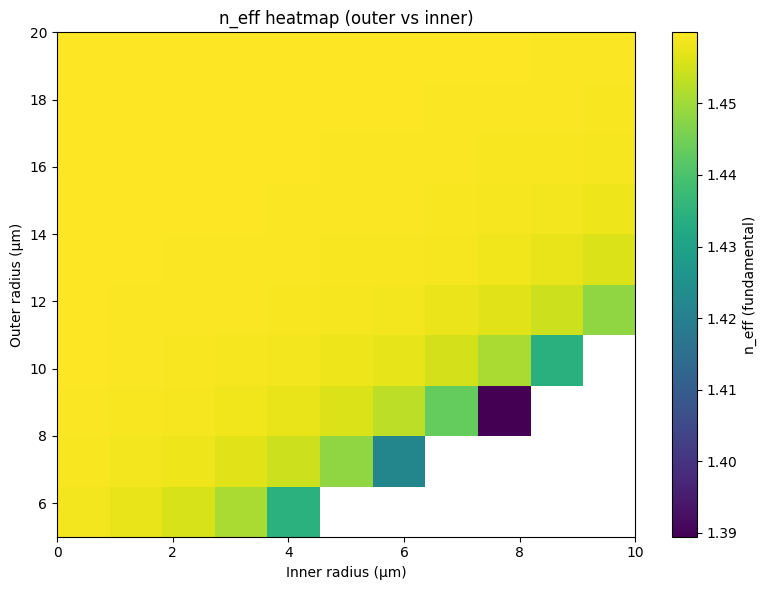

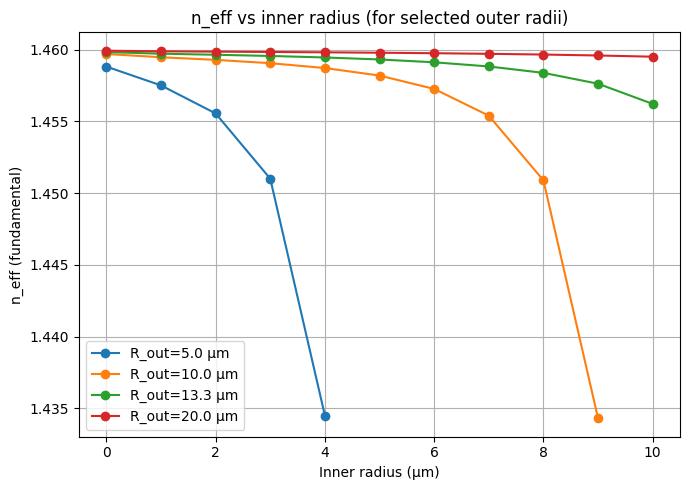

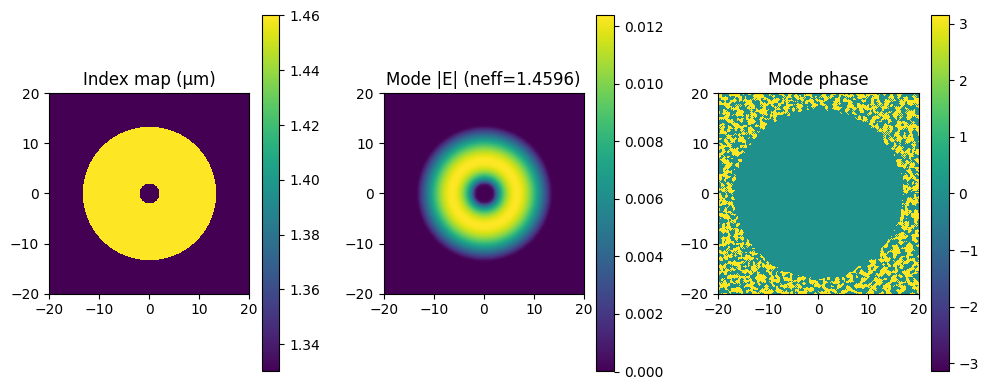

All figures and arrays stored in: sweep_outputs


In [17]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import os


wavelength = 0.8
k0 = 2 * np.pi / wavelength


nx = 201
ny = 201
dx = 0.2
dy = dx


n_core = 1.46
n_clad = 1.33
n_inner = 1.33


outer_radii = np.linspace(5.0, 20.0, 10)
inner_radii = np.linspace(0.0, 10.0, 11)


nev = 3
which_ev = "LM"


outdir = "sweep_outputs"
os.makedirs(outdir, exist_ok=True)

x = (np.arange(nx) - nx//2) * dx
y = (np.arange(ny) - ny//2) * dy
X, Y = np.meshgrid(x, y, indexing='xy')
R = np.sqrt(X**2 + Y**2)


def build_laplacian(Nx, Ny, dx, dy):
    N = Nx * Ny
    # main diagonal
    main = -2.0 / dx**2 - 2.0 / dy**2
    diag0 = main * np.ones(N)


    diag_x = 1.0 / dx**2 * np.ones(N - 1)
    for row in range(1, Ny):
        diag_x[row * Nx - 1] = 0.0


    diag_y = 1.0 / dy**2 * np.ones(N - Nx)

    offsets = [0, -1, 1, -Nx, Nx]
    diags_list = [diag0, diag_x, diag_x, diag_y, diag_y]

    L = sp.diags(diags_list, offsets, shape=(N, N), format='csr')
    return L

L = build_laplacian(nx, ny, dx, dy)


def make_index_profile(R_grid, r_in, r_out):

    n2 = np.ones_like(R_grid) * n_clad

    if r_in > 0:
        n2[R_grid < r_in] = n_inner

    if r_out > r_in:
        shell_mask = (R_grid >= r_in) & (R_grid <= r_out)
        n2[shell_mask] = n_core
    return n2

def compute_neff_for_geometry(r_in, r_out):
    n_map = make_index_profile(R, r_in, r_out)
    n_flat = n_map.ravel()

    A = L + sp.diags((k0**2) * (n_flat**2), 0, format='csr')


    try:
        vals, vecs = spla.eigs(A, k=nev, which=which_ev, tol=1e-6, maxiter=1000)
    except Exception as e:

        vals, vecs = spla.eigs(A, k=1, which='SM', tol=1e-6, maxiter=1000)


    order = np.argsort(-np.real(vals))
    vals = vals[order]
    vecs = vecs[:, order]


    beta2 = vals

    beta = np.sqrt(beta2)
    neff = beta / k0

    return np.real(neff[0]), vecs[:, 0].reshape((ny, nx)), n_map


neff_grid = np.full((len(outer_radii), len(inner_radii)), np.nan)

for i_out, r_out in enumerate(outer_radii):
    for j_in, r_in in enumerate(inner_radii):
        if r_in >= r_out:
            continue
        try:
            neff_val, mode_field, n_map = compute_neff_for_geometry(r_in, r_out)
            neff_grid[i_out, j_in] = neff_val
            print(f"R_out={r_out:.2f} µm, R_in={r_in:.2f} µm -> neff={neff_val:.6f}")
        except Exception as e:
            print(f"FAILED for R_out={r_out:.2f}, R_in={r_in:.2f}: {e}")
            neff_grid[i_out, j_in] = np.nan


np.save(os.path.join(outdir, "outer_radii.npy"), outer_radii)
np.save(os.path.join(outdir, "inner_radii.npy"), inner_radii)
np.save(os.path.join(outdir, "neff_grid.npy"), neff_grid)
print("Sweep finished and saved.")



plt.figure(figsize=(8,6))

im = plt.imshow(neff_grid, origin='lower',
                extent=[inner_radii[0], inner_radii[-1], outer_radii[0], outer_radii[-1]],
                aspect='auto', vmin=np.nanmin(neff_grid), vmax=np.nanmax(neff_grid))
plt.colorbar(im, label='n_eff (fundamental)')
plt.xlabel("Inner radius (µm)")
plt.ylabel("Outer radius (µm)")
plt.title("n_eff heatmap (outer vs inner)")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "neff_heatmap.png"), dpi=300)
plt.show()


selected_outer_indices = [0, len(outer_radii)//3, len(outer_radii)//2, -1]
plt.figure(figsize=(7,5))
for idx in selected_outer_indices:
    plt.plot(inner_radii, neff_grid[idx, :], '-o', label=f"R_out={outer_radii[idx]:.1f} µm")
plt.xlabel("Inner radius (µm)")
plt.ylabel("n_eff (fundamental)")
plt.title("n_eff vs inner radius (for selected outer radii)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(outdir, "neff_vs_inner_slices.png"), dpi=300)
plt.show()


example_idx_out = len(outer_radii)//2
example_idx_in = len(inner_radii)//4
if not np.isnan(neff_grid[example_idx_out, example_idx_in]):
    r_out_example = outer_radii[example_idx_out]
    r_in_example = inner_radii[example_idx_in]
    neff_example, mode_field_example, n_map_example = compute_neff_for_geometry(r_in_example, r_out_example)
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.imshow(n_map_example, origin='lower', extent=[x[0], x[-1], y[0], y[-1]])
    plt.title("Index map (µm)")
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.imshow(np.abs(mode_field_example), origin='lower', extent=[x[0], x[-1], y[0], y[-1]])
    plt.title(f"Mode |E| (neff={neff_example:.4f})")
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.imshow(np.angle(mode_field_example), origin='lower', extent=[x[0], x[-1], y[0], y[-1]], vmin=-np.pi, vmax=np.pi)
    plt.title("Mode phase")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "example_mode_profile.png"), dpi=300)
    plt.show()

print(f"All figures and arrays stored in: {outdir}")
